# 1 Configuring the Data

*In this module we will use Deep Learning techniques to predict the sale prices of houses.*

## 1.1 Exploratory Data Analysis 

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

PATH='./data/'

In [3]:
!ls {PATH}

data_description.txt   sample_submission.csv.gz  tmp
models		       test.csv			 train.csv
sample_submission.csv  test.csv.gz		 train.csv.gz


**Feature Space:**


*train:* training set provided by competition

*test*: test set

*data_description.txt:* full description of each column, originally prepared by Dean De Cock but lightly edited to match the column names used here

In [4]:
table_names = ['train', 'test']

In [5]:
tables = [pd.read_csv(f'{PATH}{tname}.csv', low_memory=False) for tname in table_names]

Let's kick off our EDA by taking a look at the initital raw competition data provided (before any data cleaning / feature engineering).

In [6]:
from IPython.display import HTML

In [7]:
for t in tables: display(t.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


This is a pretty typical dataset with numerous attributes provided to describe homes. Our goal in this module is to use a neural net to learn a function that uses all of these attributes as inputs to a function that will output a single number: the sale price of the house.

In [8]:
train_table = tables[0]
test_table = tables[1]

## 1.2 Data Cleaning 

Let's examine percentage of missing values across categories

In [9]:
def show_missing():
    return train_table.columns[train_table.isnull().any()].tolist()

In [10]:
round(train_table[show_missing()].isnull().sum().sort_values(ascending = False)/len(train_table)*100,2)

PoolQC          99.52
MiscFeature     96.30
Alley           93.77
Fence           80.75
FireplaceQu     47.26
LotFrontage     17.74
GarageYrBlt      5.55
GarageType       5.55
GarageFinish     5.55
GarageQual       5.55
GarageCond       5.55
BsmtFinType2     2.60
BsmtExposure     2.60
BsmtFinType1     2.53
BsmtCond         2.53
BsmtQual         2.53
MasVnrArea       0.55
MasVnrType       0.55
Electrical       0.07
dtype: float64

Since PoolQC, MiscFeature, Alley and Fence have an overwhelming majority of their values missing (over 80%), we will drop these columns from our dataset.

In [11]:
drop_cats = ['PoolQC', 'MiscFeature', 'Alley', 'Fence']

In [12]:
for c in drop_cats:
    train_table.drop(c, inplace=True, axis=1)
    test_table.drop(c, inplace=True, axis=1)

We will impute missing LotFrontage values with its categorical median

In [13]:
train_table['LotFrontage'] = train_table['LotFrontage'].fillna(train_table['LotFrontage'].median())

FireplaceQu is missing ~50% of its values. However, we make the assumption that this is because some houses don't have fireplaces and it is these very same houses that are missing FireplaceQu values. Let's confirm our assumption first.

In [14]:
train_table[train_table['FireplaceQu'].isnull()][['Fireplaces','FireplaceQu']]

,Fireplaces,FireplaceQu
0,0,NaN
5,0,NaN
10,0,NaN
12,0,NaN
15,0,NaN
17,0,NaN
18,0,NaN
19,0,NaN
26,0,NaN
29,0,NaN


As expected, houses with 0 fireplaces are missing values for FireplaceQu. Hence, our assumption was correct. We can now impute the missing values with a new category called 'None'.

In [15]:
train_table['FireplaceQu'] = train_table['FireplaceQu'].fillna('None')

In [16]:
# confirmation
train_table[train_table['FireplaceQu'].isnull()][['Fireplaces','FireplaceQu']]

,Fireplaces,FireplaceQu


GarageYrBlt, GarageType, GarageFinish,GarageQual, and GarageCond are all missing exactly 5.5% of observations. These null values are assumed to be for the (same) homes that do not have garages at all. If these assumptions are correct, the nulls can be inputed with zero as these are properties without garages.

In [17]:
garage_missing_cats = ['GarageYrBlt', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
for c in garage_missing_cats:
    print(train_table[train_table[c].isnull()][['GarageCars']+garage_missing_cats])

      GarageCars  GarageYrBlt GarageType GarageFinish GarageQual GarageCond
39             0          NaN        NaN          NaN        NaN        NaN
48             0          NaN        NaN          NaN        NaN        NaN
78             0          NaN        NaN          NaN        NaN        NaN
88             0          NaN        NaN          NaN        NaN        NaN
89             0          NaN        NaN          NaN        NaN        NaN
99             0          NaN        NaN          NaN        NaN        NaN
108            0          NaN        NaN          NaN        NaN        NaN
125            0          NaN        NaN          NaN        NaN        NaN
127            0          NaN        NaN          NaN        NaN        NaN
140            0          NaN        NaN          NaN        NaN        NaN
148            0          NaN        NaN          NaN        NaN        NaN
155            0          NaN        NaN          NaN        NaN        NaN
163         

Once again, we can see from above that our assumption was correct. We can now proceed to impute these values with zeros/Nones. 

In [18]:
for cols in garage_missing_cats:
    if train_table[cols].dtype == np.object:
         train_table[cols] = train_table[cols].fillna('None')
    else:
         train_table[cols] = train_table[cols].fillna(0)

In [19]:
# confirmation
for c in garage_missing_cats:
    print(train_table[train_table[c].isnull()][['GarageCars']+garage_missing_cats])

Empty DataFrame
Columns: [GarageCars, GarageYrBlt, GarageType, GarageFinish, GarageQual, GarageCond]
Index: []
Empty DataFrame
Columns: [GarageCars, GarageYrBlt, GarageType, GarageFinish, GarageQual, GarageCond]
Index: []
Empty DataFrame
Columns: [GarageCars, GarageYrBlt, GarageType, GarageFinish, GarageQual, GarageCond]
Index: []
Empty DataFrame
Columns: [GarageCars, GarageYrBlt, GarageType, GarageFinish, GarageQual, GarageCond]
Index: []
Empty DataFrame
Columns: [GarageCars, GarageYrBlt, GarageType, GarageFinish, GarageQual, GarageCond]
Index: []


In [20]:
# add latitude info
train_table["Lat"] = train_table.Neighborhood.replace({'Blmngtn' : 42.062806,
                                               'Blueste' : 42.009408,
                                                'BrDale' : 42.052500,
                                                'BrkSide': 42.033590,
                                                'ClearCr': 42.025425,
                                                'CollgCr': 42.021051,
                                                'Crawfor': 42.025949,
                                                'Edwards': 42.022800,
                                                'Gilbert': 42.027885,
                                                'GrnHill': 42.000854,
                                                'IDOTRR' : 42.019208,
                                                'Landmrk': 42.044777,
                                                'MeadowV': 41.991866,
                                                'Mitchel': 42.031307,
                                                'NAmes'  : 42.042966,
                                                'NoRidge': 42.050307,
                                                'NPkVill': 42.050207,
                                                'NridgHt': 42.060356,
                                                'NWAmes' : 42.051321,
                                                'OldTown': 42.028863,
                                                'SWISU'  : 42.017578,
                                                'Sawyer' : 42.033611,
                                                'SawyerW': 42.035540,
                                                'Somerst': 42.052191,
                                                'StoneBr': 42.060752,
                                                'Timber' : 41.998132,
                                                'Veenker': 42.040106})
# ----------------------------------------------------------------------------------------------------- #
test_table["Lat"] = test_table.Neighborhood.replace({'Blmngtn' : 42.062806,
                                               'Blueste' : 42.009408,
                                                'BrDale' : 42.052500,
                                                'BrkSide': 42.033590,
                                                'ClearCr': 42.025425,
                                                'CollgCr': 42.021051,
                                                'Crawfor': 42.025949,
                                                'Edwards': 42.022800,
                                                'Gilbert': 42.027885,
                                                'GrnHill': 42.000854,
                                                'IDOTRR' : 42.019208,
                                                'Landmrk': 42.044777,
                                                'MeadowV': 41.991866,
                                                'Mitchel': 42.031307,
                                                'NAmes'  : 42.042966,
                                                'NoRidge': 42.050307,
                                                'NPkVill': 42.050207,
                                                'NridgHt': 42.060356,
                                                'NWAmes' : 42.051321,
                                                'OldTown': 42.028863,
                                                'SWISU'  : 42.017578,
                                                'Sawyer' : 42.033611,
                                                'SawyerW': 42.035540,
                                                'Somerst': 42.052191,
                                                'StoneBr': 42.060752,
                                                'Timber' : 41.998132,
                                                'Veenker': 42.040106})


In [21]:
# add longitude info
train_table["Lon"] = train_table.Neighborhood.replace({'Blmngtn' : -93.639963,
                                               'Blueste' : -93.645543,
                                                'BrDale' : -93.628821,
                                                'BrkSide': -93.627552,
                                                'ClearCr': -93.675741,
                                                'CollgCr': -93.685643,
                                                'Crawfor': -93.620215,
                                                'Edwards': -93.663040,
                                                'Gilbert': -93.615692,
                                                'GrnHill': -93.643377,
                                                'IDOTRR' : -93.623401,
                                                'Landmrk': -93.646239,
                                                'MeadowV': -93.602441,
                                                'Mitchel': -93.626967,
                                                'NAmes'  : -93.613556,
                                                'NoRidge': -93.656045,
                                                'NPkVill': -93.625827,
                                                'NridgHt': -93.657107,
                                                'NWAmes' : -93.633798,
                                                'OldTown': -93.615497,
                                                'SWISU'  : -93.651283,
                                                'Sawyer' : -93.669348,
                                                'SawyerW': -93.685131,
                                                'Somerst': -93.643479,
                                                'StoneBr': -93.628955,
                                                'Timber' : -93.648335,
                                                'Veenker': -93.657032})
# ---------------------------------------------------------------------------------------------------------------- #
test_table["Lon"] = test_table.Neighborhood.replace({'Blmngtn' : -93.639963,
                                               'Blueste' : -93.645543,
                                                'BrDale' : -93.628821,
                                                'BrkSide': -93.627552,
                                                'ClearCr': -93.675741,
                                                'CollgCr': -93.685643,
                                                'Crawfor': -93.620215,
                                                'Edwards': -93.663040,
                                                'Gilbert': -93.615692,
                                                'GrnHill': -93.643377,
                                                'IDOTRR' : -93.623401,
                                                'Landmrk': -93.646239,
                                                'MeadowV': -93.602441,
                                                'Mitchel': -93.626967,
                                                'NAmes'  : -93.613556,
                                                'NoRidge': -93.656045,
                                                'NPkVill': -93.625827,
                                                'NridgHt': -93.657107,
                                                'NWAmes' : -93.633798,
                                                'OldTown': -93.615497,
                                                'SWISU'  : -93.651283,
                                                'Sawyer' : -93.669348,
                                                'SawyerW': -93.685131,
                                                'Somerst': -93.643479,
                                                'StoneBr': -93.628955,
                                                'Timber' : -93.648335,
                                                'Veenker': -93.657032})

We do not need to do extensive feature engineering like we would need to do if we were using gradient boosting, random forests or other ML techniques. This is one of the main advantages of neural networks as they tend to learn features and relationships between them more readily with minimal human intervention. Since the data looks mostly clean, we can proceed to feed it through a neural net.

In [22]:
train_table.T.head(80)

,0,1,2,3,4,5,6,7,8,9,...,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459
Id,1,2,3,4,5,6,7,8,9,10,...,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460
MSSubClass,60,20,60,70,60,50,20,60,50,190,...,90,20,180,20,20,60,20,70,20,20
MSZoning,RL,RL,RL,RL,RL,RL,RL,RL,RM,RL,...,RL,RL,RM,RL,FV,RL,RL,RL,RL,RL
LotFrontage,65,80,68,60,84,85,75,69,51,50,...,60,78,35,90,62,62,85,66,68,75
LotArea,8450,9600,11250,9550,14260,14115,10084,10382,6120,7420,...,9000,9262,3675,17217,7500,7917,13175,9042,9717,9937
Street,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,...,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave
LotShape,Reg,Reg,IR1,IR1,IR1,IR1,Reg,IR1,Reg,Reg,...,Reg,Reg,Reg,Reg,Reg,Reg,Reg,Reg,Reg,Reg
LandContour,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,...,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl
Utilities,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,...,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub
LotConfig,Inside,FR2,Inside,Corner,FR2,Inside,Inside,Corner,Inside,Corner,...,FR2,Inside,Inside,Inside,Inside,Inside,Inside,Inside,Inside,Inside


# 2 Deep Learning Approach

## 2.1 Setup

Now, we need to convert our input to make it compatible with a neural network. This includes converting categorical variables into contiguous integers using embedding matrices, normalizing continuous features to standard normal (since neural nets work better when floating point numerical values are between 0 and 1) etc.

In [23]:
# categorical variables in the dataset
categorical_vars = ['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
                    'LandSlope', 'Neighborhood', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle',
                    'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
                    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
                    'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 
                    'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive',
                    'SaleType', 'SaleCondition', 'Condition1', 'Condition2', 'YearBuilt', 
                    'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
                    'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces']

In [24]:
# continuous variables in the dataset
continuous_vars = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                   '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
                   'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'Lat', 'Lon']

In [25]:
len(categorical_vars) + len(continuous_vars)

77

In [26]:
num_rows = len(train_table); num_rows

1460

We have 1460 rows in our dataset

In [27]:
dep = 'SalePrice' # the dependent variable (what we're trying to predict)

In [28]:
# tell pandas to treat categorical variables as such
for cat_var in categorical_vars:
    train_table[cat_var] = train_table[cat_var].astype('category').cat.as_ordered()
    test_table[cat_var] = test_table[cat_var].astype('category').cat.as_ordered()

In [29]:
# apply same one-hot encoding for categorical variables in both the training and test set
apply_cats(train_table, test_table)

In [30]:
# tell pandas to treat continuous variables as 32bit floating point values as expected by pytorch
for v in continuous_vars:
    train_table[v] = train_table[v].fillna(0).astype('float32')
    test_table[v] = test_table[v].fillna(0).astype('float32')

Now we are ready to process our dataframe. This involves removing the dependent variable from the dataframe and storing it in a separate variable, creating a one-hot encoding mapping for cetegorical variables and normalizing continuous variables

In [31]:
df, y, nas, mapper = proc_df(train_table, dep, do_scale=True, skip_flds=['Id'])
yl = np.log(y)

In [32]:
df_test, _, nas, mapper = proc_df(test_table, do_scale=True, skip_flds=['Id'],
                                  mapper=mapper, na_dict=nas)

In [33]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Lat,Lon
0,6,4,-0.220875,-0.207142,2,4,4,1,5,1,...,-0.116339,-0.270208,-0.068692,-0.087688,2,3,9,5,-0.937950,-1.692052
1,1,4,0.460320,-0.091886,2,4,4,1,3,1,...,-0.116339,-0.270208,-0.068692,-0.087688,5,2,9,5,0.356167,-0.585358
2,6,4,-0.084636,0.073480,2,1,4,1,5,1,...,-0.116339,-0.270208,-0.068692,-0.087688,9,3,9,5,-0.937950,-1.692052
3,7,4,-0.447940,-0.096897,2,1,4,1,1,1,...,-0.116339,-0.270208,-0.068692,-0.087688,2,1,9,1,-0.605355,0.838207
4,6,4,0.641972,0.375148,2,1,4,1,3,1,...,-0.116339,-0.270208,-0.068692,-0.087688,12,3,9,5,1.048815,-0.547298


In [34]:
y

array([208500, 181500, 223500, 140000, 250000, 143000, 307000, 200000, 129900, 118000, 129500, 345000,
       144000, 279500, 157000, 132000, 149000,  90000, 159000, 139000, ..., 191000, 149300, 310000, 121000,
       179600, 129000, 157900, 240000, 112000,  92000, 136000, 287090, 145000,  84500, 185000, 175000,
       210000, 266500, 142125, 147500])

Thus, we can see that the dependent variable has been removed from the original dataframe and stored in `y`.

In [35]:
val = get_cv_idxs(num_rows - 1); len(val)

291

Since this is not a time series prediction task, it is ok to just take random indexes for validation.

In [36]:
# define competition evaluation metric
def rmsle(y_pred, targ):
    return np.sqrt(((targ - y_pred)**2).mean())

## 2.2 Training

In [37]:
md = ColumnarModelData.from_data_frame(PATH, val, df, yl.astype(np.float32), cat_flds=categorical_vars,
                                       bs=128, test_df=df_test)

Now we need to determine the size of the embedding matrices for our categorical variables.

Let's begin by examining the sizes of each of our categorical variables.

In [38]:
cat_sz = [(c, len(train_table[c].cat.categories)+1) for c in categorical_vars] # add 1 for unknown values / NAs etc.

In [39]:
cat_sz

[('MSSubClass', 17),
 ('MSZoning', 6),
 ('Street', 3),
 ('LotShape', 5),
 ('LandContour', 5),
 ('Utilities', 2),
 ('LotConfig', 6),
 ('LandSlope', 4),
 ('Neighborhood', 26),
 ('BldgType', 6),
 ('HouseStyle', 8),
 ('OverallQual', 11),
 ('OverallCond', 10),
 ('RoofStyle', 7),
 ('RoofMatl', 5),
 ('Exterior1st', 14),
 ('Exterior2nd', 16),
 ('MasVnrType', 5),
 ('ExterQual', 5),
 ('ExterCond', 6),
 ('Foundation', 7),
 ('BsmtQual', 5),
 ('BsmtCond', 5),
 ('BsmtExposure', 5),
 ('BsmtFinType1', 7),
 ('BsmtFinType2', 7),
 ('Heating', 5),
 ('HeatingQC', 6),
 ('CentralAir', 3),
 ('Electrical', 5),
 ('KitchenQual', 5),
 ('Functional', 8),
 ('FireplaceQu', 6),
 ('GarageType', 7),
 ('GarageFinish', 4),
 ('GarageCars', 7),
 ('GarageQual', 5),
 ('GarageCond', 6),
 ('PavedDrive', 4),
 ('SaleType', 10),
 ('SaleCondition', 7),
 ('Condition1', 10),
 ('Condition2', 6),
 ('YearBuilt', 107),
 ('YearRemodAdd', 62),
 ('GarageYrBlt', 98),
 ('MoSold', 13),
 ('YrSold', 6),
 ('BsmtFullBath', 5),
 ('BsmtHalfBath', 4

We use the cardinality of each variable (that is, its number of unique values) to decide how large to make its embeddings. Each level will be associated with a vector with length defined as below.

In [40]:
# rule of thumb: make embeddings half the size of the cardinality but <= 50
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [41]:
emb_szs

[(17, 9),
 (6, 3),
 (3, 2),
 (5, 3),
 (5, 3),
 (2, 1),
 (6, 3),
 (4, 2),
 (26, 13),
 (6, 3),
 (8, 4),
 (11, 6),
 (10, 5),
 (7, 4),
 (5, 3),
 (14, 7),
 (16, 8),
 (5, 3),
 (5, 3),
 (6, 3),
 (7, 4),
 (5, 3),
 (5, 3),
 (5, 3),
 (7, 4),
 (7, 4),
 (5, 3),
 (6, 3),
 (3, 2),
 (5, 3),
 (5, 3),
 (8, 4),
 (6, 3),
 (7, 4),
 (4, 2),
 (7, 4),
 (5, 3),
 (6, 3),
 (4, 2),
 (10, 5),
 (7, 4),
 (10, 5),
 (6, 3),
 (107, 50),
 (62, 31),
 (98, 49),
 (13, 7),
 (6, 3),
 (5, 3),
 (4, 2),
 (6, 3),
 (4, 2),
 (8, 4),
 (4, 2),
 (13, 7),
 (6, 3)]

In [43]:
learn = md.get_learner(emb_szs, len(df.columns)-len(categorical_vars),
                   0.04, 1, [1000,500], [0.001,0.01])

In [44]:
learn.lr_find()

epoch      trn_loss   val_loss                               
    0      69377438.470207 7006607.955326



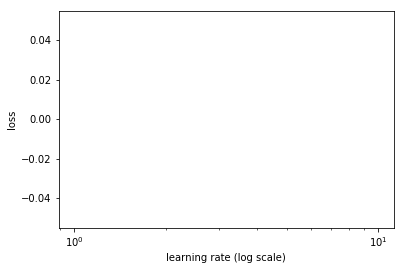

In [45]:
learn.sched.plot()

In [46]:
lr = 1e-2

In [47]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2, metrics=[rmsle], wds=1e-5)

epoch      trn_loss   val_loss   rmsle                   
    0      97.138023  66.615472  8.161751  
    1      55.71947   10.629091  3.260172                
    2      37.10063   6.980858   2.642102                
    3      28.140133  13.268836  3.642362                
    4      21.645625  3.434663   1.853161                
    5      16.360352  1.360854   1.166541                
    6      12.64915   0.961505   0.980454                



[array([0.96151]), 0.9804537297191083]

We can see above that the model is coverging, but the wide gap between the training loss and validation loss is indication that the model is underfitting. We will seek to remedy this by reducing dropout in the later layers and trying again.

In [53]:
learn.fit(lr, 5, cycle_len=1, cycle_mult=2, metrics=[rmsle], wds=1e-6)

epoch      trn_loss   val_loss   rmsle                   
    0      1.01588    0.277936   0.526868  
    1      1.497424   0.292768   0.541057                
    2      1.093374   0.124548   0.352895                
    3      1.162259   1.993386   1.411791                
    4      0.995131   0.171459   0.414065                 
    5      0.793367   0.067449   0.259411                 
    6      0.686167   0.052804   0.229791                 
    7      0.560253   0.043209   0.207866                 
    8      0.450617   0.045599   0.213538                 
    9      0.378257   0.068525   0.26172                  
    10     0.312341   0.031125   0.176401                 
    11     0.258666   0.038091   0.195149                 
    12     0.215905   0.031247   0.17675                  
    13     0.181129   0.033941   0.184211                 
    14     0.15348    0.033172   0.182103                 
    15     0.132265   0.055121   0.234764                 
    16     0.117

[array([0.0301]), 0.17337305095331002]

We have reduced the Root Mean Square Log Error to ~0.14 on the training set. Let's go ahead and run on the test set.

## 2.3 Predict on Test Set

In [54]:
predictions = learn.predict(is_test=True)
predictions = np.exp(predictions)

In [55]:
display(predictions)

array([[111618.9  ],
       [170108.6  ],
       [176126.3  ],
       [188816.33 ],
       [176538.8  ],
       [156880.8  ],
       [156883.2  ],
       [151228.9  ],
       [167527.22 ],
       [117877.2  ],
       [157734.11 ],
       [ 84466.6  ],
       [ 92577.07 ],
       [134164.88 ],
       [ 97858.766],
       [318855.7  ],
       [251931.27 ],
       [266361.84 ],
       [266978.03 ],
       [536400.06 ],
       ...,
       [130937.38 ],
       [152528.28 ],
       [167454.22 ],
       [327904.78 ],
       [333888.1  ],
       [ 67901.7  ],
       [200037.03 ],
       [108323.19 ],
       [135640.5  ],
       [134127.39 ],
       [ 75435.15 ],
       [ 80406.05 ],
       [114947.766],
       [ 70775.336],
       [ 71040.69 ],
       [ 76107.89 ],
       [ 77441.6  ],
       [158363.25 ],
       [103816.75 ],
       [196570.8  ]], dtype=float32)

## 2.4 Create a Kaggle Compatible Submission

In [56]:
len(predictions)

1459

In [57]:
len(test_table)

1459

In [58]:
test_table['SalePrice'] = predictions

In [59]:
test_table.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Lat,Lon,SalePrice
0,1461,20,RH,80.0,11622.0,Pave,Reg,Lvl,AllPub,Inside,...,120.0,0.0,0.0,6,2010,WD,Normal,42.042965,-93.613556,111618.898438
1,1462,20,RL,81.0,14267.0,Pave,IR1,Lvl,AllPub,Corner,...,0.0,0.0,12500.0,6,2010,WD,Normal,42.042965,-93.613556,170108.593750
2,1463,60,RL,74.0,13830.0,Pave,IR1,Lvl,AllPub,Inside,...,0.0,0.0,0.0,3,2010,WD,Normal,42.027885,-93.615692,176126.296875
3,1464,60,RL,78.0,9978.0,Pave,IR1,Lvl,AllPub,Inside,...,0.0,0.0,0.0,6,2010,WD,Normal,42.027885,-93.615692,188816.328125
4,1465,120,RL,43.0,5005.0,Pave,IR1,HLS,AllPub,Inside,...,144.0,0.0,0.0,1,2010,WD,Normal,42.060753,-93.628952,176538.796875


In [60]:
submission_df = test_table[['Id', 'SalePrice']]

In [61]:
submission_df.head()

,Id,SalePrice
0,1461,111618.898438
1,1462,170108.593750
2,1463,176126.296875
3,1464,188816.328125
4,1465,176538.796875


In [62]:
!mkdir subm/

mkdir: cannot create directory ‘subm/’: File exists


In [63]:
submission_df.to_csv(f'subm/subm.gz', compression='gzip', index=False)